In [70]:
import keras
from keras.applications import MobileNetV2
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Activation, Flatten, Conv2D, Conv1D,MaxPooling2D,Dropout,BatchNormalization
from keras import models
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.utils import to_categorical
import random
import pandas as pd
import numpy as np
import matplotlib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import skimage.transform
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [71]:
%%time
#Load Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Take sample
trainindex = random.sample(range(0,len(x_train)),1000)
testindex = random.sample(range(0,len(x_test)),100)

x_train = x_train[trainindex]
y_train = y_train[trainindex]
x_test = x_test[testindex]
y_test = y_test[testindex]

y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

CPU times: user 117 ms, sys: 165 ms, total: 282 ms
Wall time: 280 ms


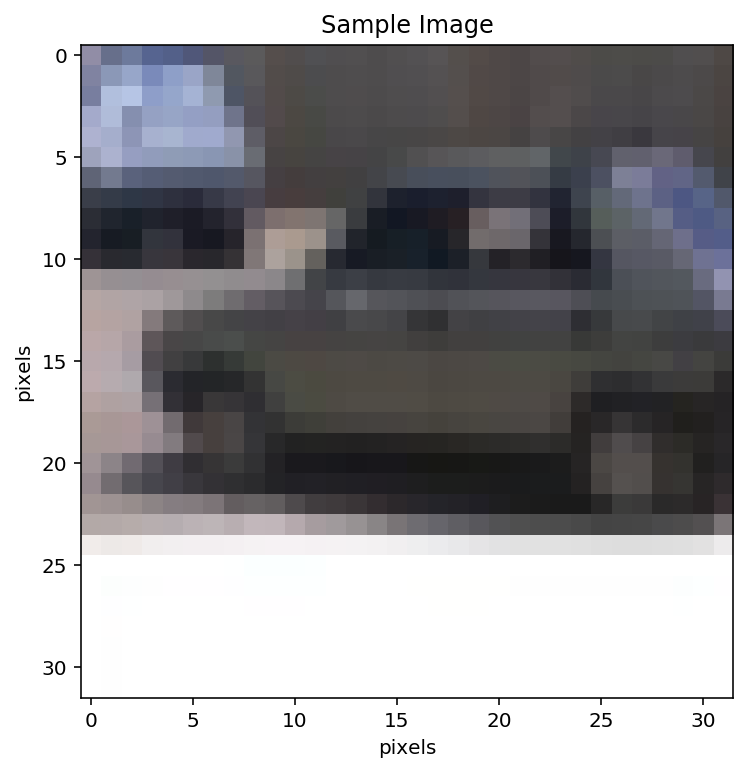

In [72]:
plt.figure(figsize=(6,6))
plt.title('Sample Image')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.imshow(x_train[7]);

In [73]:
%%time
new_train = []
new_test = []

for i,image in enumerate(x_train): 
    new_image = skimage.transform.resize(image, (96, 96,3), mode='constant')
    new_train.append(new_image)
for i,image in enumerate(x_test):
    new_image = skimage.transform.resize(image, (96, 96,3), mode='constant')
    new_test.append(new_image)

x_train = np.asarray(new_train)
x_test = np.asarray(new_test)

/Users/LiamRoberts/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


CPU times: user 1.65 s, sys: 168 ms, total: 1.82 s
Wall time: 1.81 s


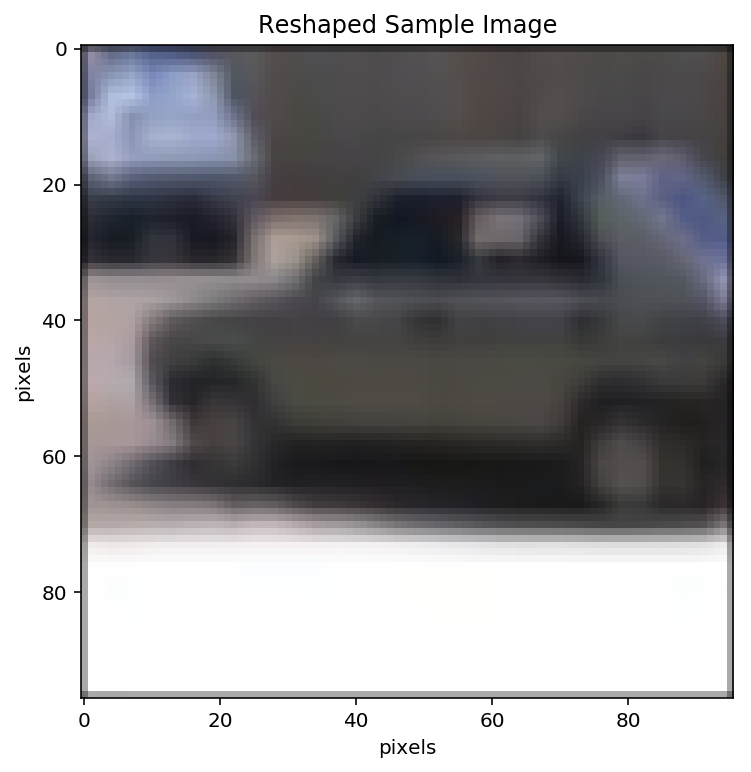

In [74]:
plt.figure(figsize=(6,6))
plt.title('Reshaped Sample Image')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.imshow(x_train[7]);

In [75]:
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(96,96,3))

In [76]:
%%time
#Get Features using Pre Trained MobileNetV2 Model (~9min/1000 images)
train_feats = conv_base.predict(x_train)
test_feats = conv_base.predict(x_test)
feat_shape = train_feats.shape
print(f'New Features Shape: {feat_shape}')

New Features Shape: (1000, 3, 3, 1280)
CPU times: user 2min 34s, sys: 18.8 s, total: 2min 53s
Wall time: 27.6 s


In [77]:
train_feats = train_feats.reshape((feat_shape[0],
                                   feat_shape[1]*feat_shape[2]*feat_shape[3]))

test_feats = test_feats.reshape((len(test_feats),
                                 feat_shape[1]*feat_shape[2]*feat_shape[3]))

In [78]:
model = models.Sequential()
model.add(Dense(256, input_dim = 3*3*1280, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               2949376   
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 2,951,946
Trainable params: 2,951,946
Non-trainable params: 0
_________________________________________________________________


In [79]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_feats, y_train, epochs=100, validation_data=(test_feats,y_test),batch_size=128,callbacks=[early_stop])

Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: 7.2377 - acc: 0.2390 - val_loss: 9.7841 - val_acc: 0.1700
Epoch 2/100
1000/1000 [==============================] - 0s 485us/step - loss: 7.1668 - acc: 0.4040 - val_loss: 8.9504 - val_acc: 0.2300
Epoch 3/100
1000/1000 [==============================] - 1s 523us/step - loss: 6.6837 - acc: 0.5090 - val_loss: 8.9225 - val_acc: 0.2900
Epoch 4/100
1000/1000 [==============================] - 1s 554us/step - loss: 6.5188 - acc: 0.5360 - val_loss: 8.7840 - val_acc: 0.2800
Epoch 5/100
1000/1000 [==============================] - 1s 527us/step - loss: 6.3938 - acc: 0.5770 - val_loss: 8.6322 - val_acc: 0.3100
Epoch 6/100
1000/1000 [==============================] - 1s 547us/step - loss: 6.3481 - acc: 0.5970 - val_loss: 8.7169 - val_acc: 0.2800
Epoch 7/100
1000/1000 [==============================] - 1s 525us/step - loss: 6.3352 - acc: 0.5990 - val_loss: 8.6839 - val_acc: 0.2